In [2]:
%matplotlib inline
import hyperspy.api as hs
Signal2D = hs.signals.Signal2D
Gaussian2D = hs.model.components2D.Gaussian2D

from ase.cluster.cubic import FaceCenteredCubic
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt

/home/thomasaar/miniconda3/envs/py/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


In [3]:
def create_model(cell, extra_space=0, pbc=True, pixel_size: "Å" =0.1):
    XLEN, YLEN = ((cell.cell.diagonal()[:2] + 2*extra_space) // pixel_size).astype(int)
    ax0 = {
        'name':'y',
        'size': YLEN,
        'offset':-extra_space,
        'scale':pixel_size, 
        'units':'Å',
    }
    ax1 = {
        'name':'x', 
        'size': XLEN, 
        'offset':-extra_space,
        'scale':pixel_size, 
        'units':'Å',
    }

    axes = [ax0, ax1]
    s = Signal2D(np.zeros((YLEN, XLEN)), axes=axes)

    m = s.create_model()


    if pbc:
        a = [-1, 0, 1]
        merge = [list(zip(x,a)) for x in permutations(a,len(a))]
        l = []
        for entry in merge:
            l += entry
        shifts = set(l)
    else:
        shifts = [0]

    cell_center = np.array([(ax.high_value + ax.scale + ax.low_value)/2 for ax in s.axes_manager.signal_axes])
    diagonal_radius = np.array([ax.high_value for ax in s.axes_manager.signal_axes])
    
    sigma = 0.4
    for atom in cell:
        for offset in shifts:
            xyposition = atom.position[:2] + cell.cell.diagonal()[:2] * offset
            if np.abs(np.linalg.norm(xyposition - cell_center)) > np.linalg.norm(cell_center - diagonal_radius) + 1:
                continue
            A = atom.number**2
            x, y = xyposition
            g = Gaussian2D(A, sigma, sigma, x, y )
            m.append(g)
    return m

def rotation_matrix(deg):
    c = np.cos(np.deg2rad(deg))
    s = np.sin(np.deg2rad(deg))
    return np.array([[c, -s],[s, c]])
    
def rotate_model(m, angle=90):
    center = cell.cell.diagonal()[:2] / 2
    cx, cy = center

    for comp in m:
        comp_center = [comp.centre_x.value, comp.centre_y.value]
        comp.centre_x.value, comp.centre_y.value = rotation_matrix(angle) @ (comp_center - center) + center
    return m

In [4]:
rotation_matrix(20) @ 

array([[ 0.93969262, -0.34202014],
       [ 0.34202014,  0.93969262]])

In [3]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [3, 4, 5]
lc = 3.61000
cell = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)
cell[46].number = 50

m = create_model(cell, extra_space=2, pbc=False)
s2 = m.as_signal()

angle = 30

m2 = rotate_model(m, angle)
s3 = m2.as_signal()

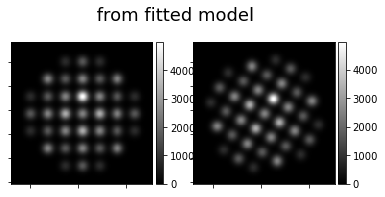

In [4]:
hs.plot.plot_images([s2, s3], axes_decor=None, );

In [5]:
drift_vector = np.array([1,0])
image_angles = np.array([0, 90])

drift_vectors = [rotation_matrix(angle) @ drift_vector for angle in image_angles]

In [6]:
def probe_positions(model, drift_vector, scale=None, scannoise=True, xlen=None, ylen=None, start: "(x,y)"=None):
    if xlen == None or ylen == None:
        xlen, ylen = m.axes_manager.signal_shape
    if scale == None:
        scale = s.axes_manager[-1].scale
    if start == None:
        start = [ax.offset for ax in m.axes_manager.signal_axes]
    X = np.zeros((ylen, xlen))
    Y = np.zeros((ylen, xlen))
    
    xdrift = 0
    ydrift = 0

    if scannoise == True:
        xnoise = np.random.random() * 0.1
    elif scannoise == False:
        xnoise = 0
    else:
        xnoise = scannoise
    
    for yi in range(ylen):
        xnoise = np.random.random() * 0.1 # flyback noise

        for xi in range(xlen):
            xdrift -= drift_vector[0]
            ydrift -= drift_vector[1]

            X[yi, xi] = xi*scale + start[0] + xdrift*scale + xnoise
            Y[yi, xi] = yi*scale + start[1] + ydrift*scale
    return X, Y

def intensity_nd(m, X, Y):
    intensity = np.zeros(X.shape)
    for comp in m:
        if comp.active:
            intensity += comp.function_nd(X, Y)
    return intensity

def image_from_probe_positions(m, XY):
    I = intensity_nd(m, *XY)
    return m.signal._deepcopy_with_new_data(I)

def drift_image(m, drift_vector, scale=None):
    XY = probe_positions(m, drift_vector=drift_vector, scale=scale)
    s = image_from_probe_positions(m, XY)
    return s

In [7]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [3, 4, 5]
lc = 3.61000
cell = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)
cell[46].number = 50

m = create_model(cell, extra_space=2, pbc=False, pixel_size=0.01)
s = m.as_signal()

angle = 0
drift_direction = [0, 1]
drift_vector = rotation_matrix(angle) @ drift_direction / 10000
s1 = drift_image(m, drift_vector)

angle = 90
rotate_model(m, angle)
drift_vector = rotation_matrix(angle) @ drift_direction / 10000
s2 = drift_image(m, drift_vector)

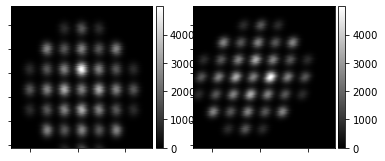

In [8]:
hs.plot.plot_images([s1, s2], axes_decor=None, );

In [9]:
s2 = s1.isig[4.4:6.3,3.5:5.6]

In [10]:
import scipy.ndimage
I2 = s2.data.copy()
xlen, ylen = I2.shape
ds = []
shifts = []
for y_index in np.arange(1, ylen):
    I_backup = I2[y_index].copy()
    y_start = y_index - 5 if y_index - 5 > 0 else 0
    y_end = y_index + 5
    d = []
    mxshift = 15
    shift_array = np.arange(-mxshift, mxshift, 1)
    for shift in shift_array:
        I2[y_index] = scipy.ndimage.shift(I_backup, shift, mode='wrap')
        diff1 = np.abs(np.diff(I2[y_start:y_end, mxshift:-mxshift], axis=0)).mean()
        diff = diff1# + diff2
        d.append(diff)
    ds.append(d)
    final_shift = shift_array[np.argmin(d)]
    shifts.append(final_shift)
    I2[y_index] = scipy.ndimage.shift(I_backup, final_shift, mode='wrap')
ds = np.array(ds)

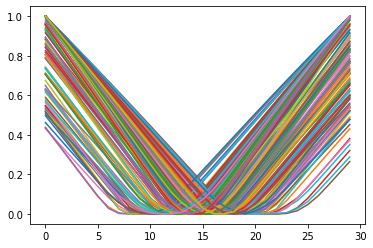

In [11]:
plt.figure()
for d in ds:
    d = d - d.min()
    d = d / d.max()
    plt.plot(d)

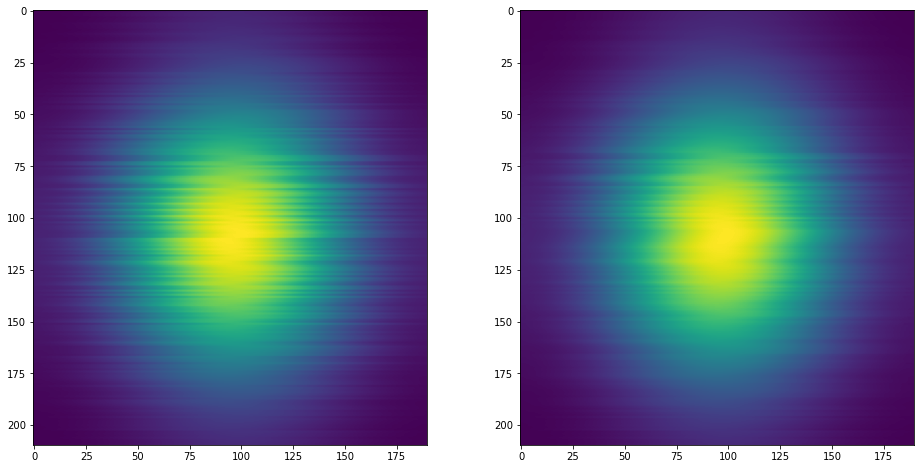

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize= (16, 8))
ax1.imshow(s2.data)
ax2.imshow(I2)

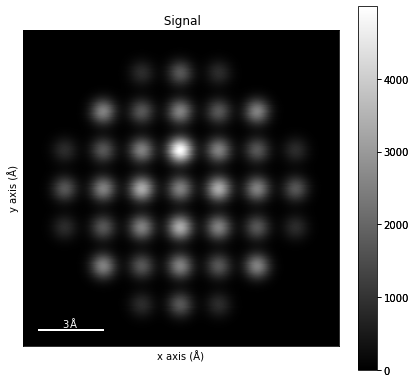

In [13]:
m = create_model(cell, extra_space=2, pbc=False, pixel_size=0.01)
s = m.as_signal()

angle = 0
drift_direction = [0, 1]
drift_vector = rotation_matrix(angle) @ drift_direction / 500000
s1 = drift_image(m, drift_vector)
s1.plot()